Zuerst werden Tweets gescrapt  

In [3]:
import snscrape.modules.twitter as sntwitter
import tqdm
import pandas as pd
from matplotlib import pyplot as plt

# Setting variables to be used below
#Create Variable with all DAX companies

dax_40_companies = ["$SAP", "$SIE", "$ALVE", "$DTEA", "$AIR", "$BASA", "$BAYN", "$MBG", "$MUV2", "$IFX", "$DB1", "$VOW3", "$DPWA", "$BMW", "$RWEA", "$MRK", "$DBK", "$ADS", "$EOAN", "$VNAA", "$SHL", "$DTG", "$ZZMS", "$SY1", "$P911", "$MXTN", "$AF4", "$FRE", "$BEI", "$HEN", "$BNR", "$QIA", "$SRT", "$ZAL", "$ENR0", "$HEIU","$PAHA", "$1COV", "$FME", "$1COV"]
# Create for loop to get all tweets from all companies and save them in one csv file ordered by date and add tqdm progress bar
tweets_df2 = pd.DataFrame()
for company in tqdm.tqdm(dax_40_companies):
    tweets_list2 = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(company + 'since:2021-09-20 until:2023-01-31').get_items()):
        if i>100000:
            break
        tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount])
    tweets_df2 = tweets_df2.append(tweets_list2, ignore_index = True)
tweets_df2.columns = ['Datetime', 'Tweet Id', 'Text', 'Username', 'Likes', 'Replies', 'Retweets', 'Quotes']
tweets_df2 = tweets_df2.sort_values(by='Datetime', ascending=False)

print(tweets_df2.head(10))
#save the data in a csv file
tweets_df2.to_csv('tweets_dax_40.csv', sep=';', index=False)

  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\Maximilian Horstmann\AppData\Local\Temp\ipykernel_12832\146361410.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweets_df2 = tweets_df2.append(tweets_list2, ignore_index = True)
 20%|██        | 8/40 [00:10<00:39,  1.24s/it]C:\Users\Maximilian Horstmann\AppData\Local\Temp\ipykernel_12832\146361410.py:17: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount])
100%|██████████| 40/40 [1:28:00<00:00, 132.02s/it]  


                       Datetime             Tweet Id  \
94472 2023-01-30 23:51:34+00:00  1620208127198244865   
94473 2023-01-30 23:47:22+00:00  1620207071592587266   
0     2023-01-30 23:46:59+00:00  1620206974389604352   
94474 2023-01-30 23:46:48+00:00  1620206929221124096   
94475 2023-01-30 23:41:13+00:00  1620205523927965696   
5267  2023-01-30 23:26:11+00:00  1620201741651435525   
5268  2023-01-30 23:07:42+00:00  1620197090411581442   
33257 2023-01-30 22:53:47+00:00  1620193588209393665   
78507 2023-01-30 22:36:25+00:00  1620189214305554432   
94476 2023-01-30 22:35:34+00:00  1620189001809539072   

                                                    Text         Username  \
94472  仕事も育児も家事もなんでもそうだけど、\n楽しようと思えばできるよね。\n真面目な人間ほど追...           bp_af4   
94473                   اللهـم القبـول الـذي .. لا يـزول            AF4__   
0                               実写のルフィ役と言われるとあの容疑者の顔が浮かぶ             MUV2   
94474  ما دمت عارف وش اللي داخلك من بياض\nما هو ضروري...            AF4__  

Data Preprocessing

In [ ]:
#Start of the Sentiment Analysis
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
import tqdm as tqdm
from scipy.special import softmax
import pandas as pd

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Load the model from /home/azureuser/cloudfiles/code/cardiffnlp/twitter-xlm-roberta-base-sentiment
MODEL = f'cardiffnlp/twitter-xlm-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

# Start of the Sentiment Analysis with the tweets from the csv file
# Load data
df = pd.read_csv('S&P40.csv',sep=";")
print("CSV LOADED")
df = df.dropna()
df['Text'] = df['Text'].apply(preprocess)
print("DATA PREPROCESSED")

# Tokenize and encode sequences in the training set
text = df['Text'].tolist()
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# Compute sentiment polarity scores in batches of 32
batch_size = 32
scores = [] 
for i in tqdm.tqdm(range(0, len(encoded_input['input_ids']), batch_size)):
    result = model(**{k: v[i:i+batch_size].to(model.device) for k, v in encoded_input.items()})
    scores.extend(result.logits.detach().cpu().numpy())

# Compute softmax probabilities
probs = softmax(np.array(scores), axis=1)

# Add predicted probabilities to the dataframe
df['Negative'] = probs[:, 0]
df['Neutral'] = probs[:, 1]
df['Positive'] = probs[:, 2]

#save data
df.to_csv('tweets_dax_40.csv',sep=";", index=False)

Show distribution of tweets

                    Datetime             Tweet Id  \
0  2023-01-30 23:51:34+00:00  1620208127198244865   
1  2023-01-30 23:47:22+00:00  1620207071592587266   
2  2023-01-30 23:46:59+00:00  1620206974389604352   
3  2023-01-30 23:46:48+00:00  1620206929221124096   
4  2023-01-30 23:41:13+00:00  1620205523927965696   

                                                Text Username  Likes  Replies  \
0  仕事も育児も家事もなんでもそうだけど、\n楽しようと思えばできるよね。\n真面目な人間ほど追...   bp_af4      4        0   
1                   اللهـم القبـول الـذي .. لا يـزول    AF4__      2        0   
2                           実写のルフィ役と言われるとあの容疑者の顔が浮かぶ     MUV2      0        0   
3  ما دمت عارف وش اللي داخلك من بياض\nما هو ضروري...    AF4__      0        0   
4  يصون الموّده من يجازا بـ وّد و طيب\nويعيف المو...    AF4__      1        0   

   Retweets  Quotes  
0         0       0  
1         1       0  
2         0       0  
3         0       0  
4         0       0  
                    Datetime             Tweet Id  \
0  2023-0

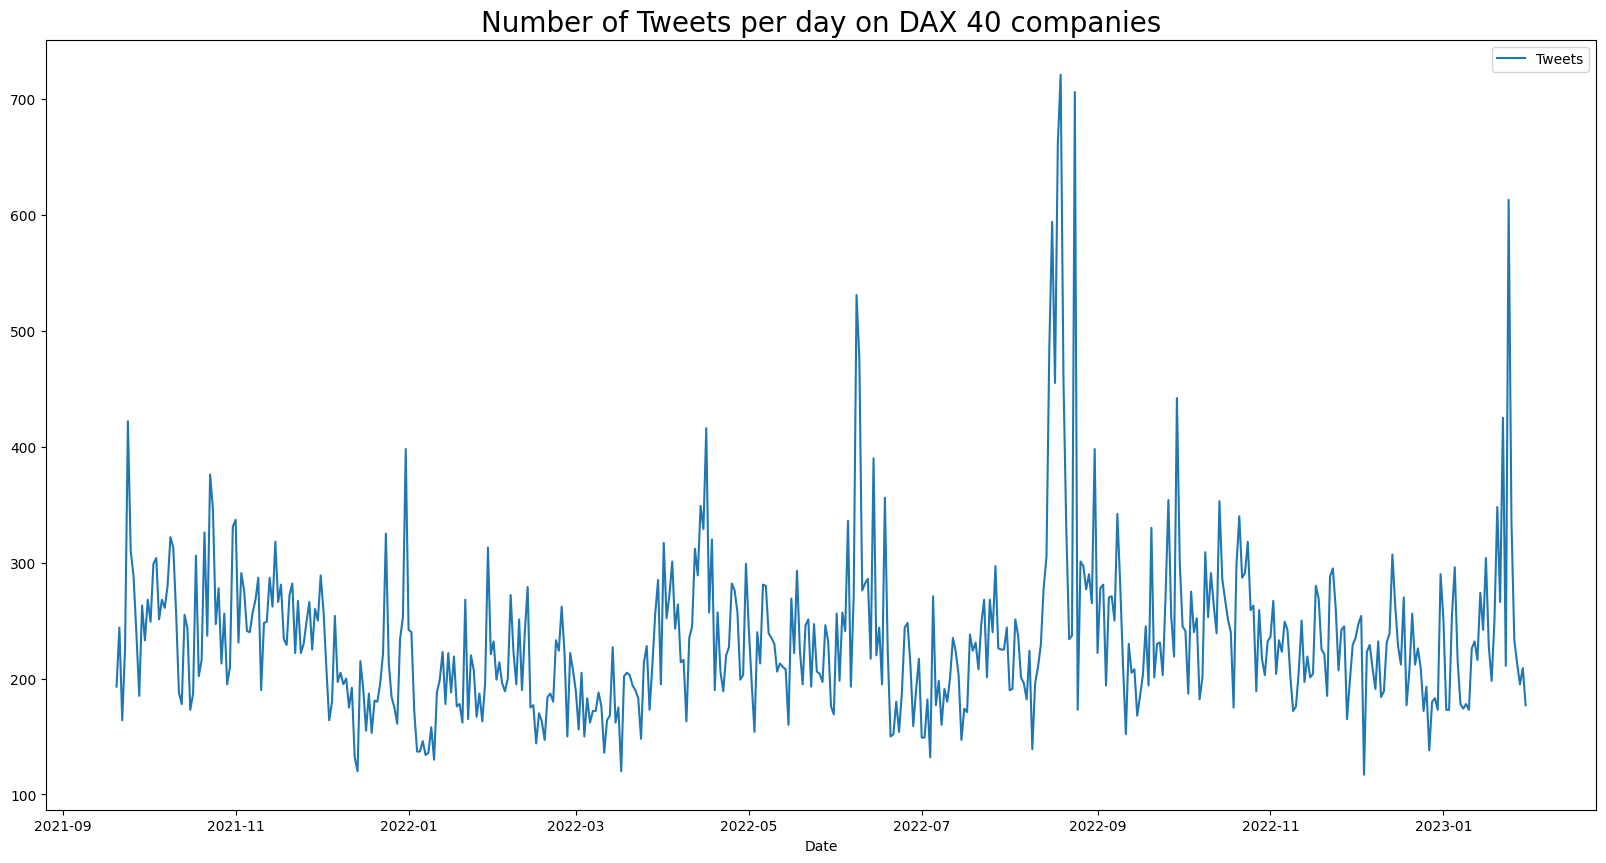

KeyError: 'Tags'

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

# Import the tagged tweets
tweets = pd.read_csv('tweets_dax_40.csv', sep=';')
print(tweets.head())

# filter out all tweets that have the same text
tweets = tweets.drop_duplicates(subset=['Text'])
print(tweets.head())

# Plot the number of tweets per day with a logatithmic scale
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'])
tweets['Date'] = tweets['Datetime'].dt.date
tweets_per_day = tweets.groupby('Date').count()
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day = tweets_per_day[['Date', 'Text']]
tweets_per_day.columns = ['Date', 'Tweets']
tweets_per_day = tweets_per_day.sort_values(by='Date', ascending=True)
tweets_per_day.plot(x='Date', y='Tweets', kind='line', figsize=(20, 10))
plt.title("Number of Tweets per day on DAX 40 companies", fontsize=20)
plt.show()

# Select only the tweets with the tag 'business'
tweets = tweets[tweets['Tags'].str.contains('business_&_entrepreneurs')]
print(tweets.head())

# Plot the number of tweets per day
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'])
tweets['Date'] = tweets['Datetime'].dt.date
tweets_per_day = tweets.groupby('Date').count()
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day = tweets_per_day[['Date', 'Text']]
tweets_per_day.columns = ['Date', 'Tweets']
tweets_per_day = tweets_per_day.sort_values(by='Date', ascending=True)
tweets_per_day.plot(x='Date', y='Tweets',title="Tweets on Business per day",kind='line', figsize=(20, 10))
plt.show()

# Save the tweets in a csv file
tweets.to_csv("tweets_dax_40_business.csv",sep=";")

# show the days with the most tweets
print(tweets_per_day.sort_values(by='Tweets', ascending=False).head(10))

Add a wordcloud to analyse which word are used the most

In [1]:
#import libraries for wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Read the csv file
tweets = pd.read_csv('tweets_dax_40_business.csv', sep=';')
print(tweets.head())

#take summary statistics by day
#calculate mean submissions per day
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'])

tweets['Date'] = tweets['Datetime'].dt.date
tweets_per_day = tweets.groupby('Date').count()
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day = tweets_per_day[['Date', 'Text']]
tweets_per_day.columns = ['Date', 'Tweets']
tweets_per_day = tweets_per_day.sort_values(by='Date', ascending=True)
print(tweets_per_day.head())

#calculate mean submissions per day
print(tweets_per_day['Tweets'].mean())
#calculate stddv submissions per day
print(tweets_per_day['Tweets'].std())
print(tweets_per_day['Tweets'].min())

#calculate 25th percentile submissions per day
print(tweets_per_day['Tweets'].quantile(0.25))

#show the days with the most tweets
print(tweets_per_day.sort_values(by='Tweets', ascending=False).head(10))



   Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
0             0             0             0             0             0   
1             1             1             1             1             1   
2             2             2             2             2             2   
3             3             3             3             3             3   
4             4             4             4             4             4   

   Unnamed: 0                   Datetime             Tweet Id  \
0           0  2023-01-30 23:59:31+00:00  1620210130066329602   
1           1  2023-01-30 23:59:11+00:00  1620210047077781505   
2           2  2023-01-30 23:58:53+00:00  1620209971802836993   
3           3  2023-01-30 23:58:52+00:00  1620209964597006336   
4           4  2023-01-30 23:58:49+00:00  1620209954857824258   

                                                Text      Username  Likes  \
0  Tritratrullala oida grantler zoe gruene Ich mu...    GernotSchu    0.0   
1  F

Create Sentiment score

   Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0             0             0             0             0           0   
1             1             1             1             1           1   
2             2             2             2             2           2   
3             3             3             3             3           3   
4             4             4             4             4           4   

                    Datetime             Tweet Id  \
0  2023-01-30 23:59:31+00:00  1620210130066329602   
1  2023-01-30 23:59:11+00:00  1620210047077781505   
2  2023-01-30 23:58:53+00:00  1620209971802836993   
3  2023-01-30 23:58:52+00:00  1620209964597006336   
4  2023-01-30 23:58:49+00:00  1620209954857824258   

                                                Text      Username  Likes  \
0  Tritratrullala oida grantler zoe gruene Ich mu...    GernotSchu    0.0   
1  Fuxelbau Ich nicht Ich kann dir f r deine Raid...        Heikus    0.0   
2  NeuroDoc

C:\Users\Maximilian Horstmann\AppData\Local\Temp\ipykernel_17216\2825468447.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_per_day = tweets.groupby('Date').mean()


             Unnamed: 0.4   Unnamed: 0.3   Unnamed: 0.2   Unnamed: 0.1  \
Date                                                                     
2021-09-20  199109.880000  199109.880000  199109.880000  199109.880000   
2021-09-21  198981.011494  198981.011494  198981.011494  198981.011494   
2021-09-22  198869.177966  198869.177966  198869.177966  198869.177966   
2021-09-23  198739.656000  198739.656000  198739.656000  198739.656000   
2021-09-24  198604.609756  198604.609756  198604.609756  198604.609756   

               Unnamed: 0      Tweet Id      Likes   Replies  Retweets  \
Date                                                                     
2021-09-20  199109.880000  1.439949e+18   4.953333  0.940000  0.260000   
2021-09-21  198981.011494  1.440304e+18   5.919540  0.528736  0.379310   
2021-09-22  198869.177966  1.440665e+18  10.050847  0.754237  0.559322   
2021-09-23  198739.656000  1.441032e+18   7.632000  0.504000  0.224000   
2021-09-24  198604.609756  1.441386e+

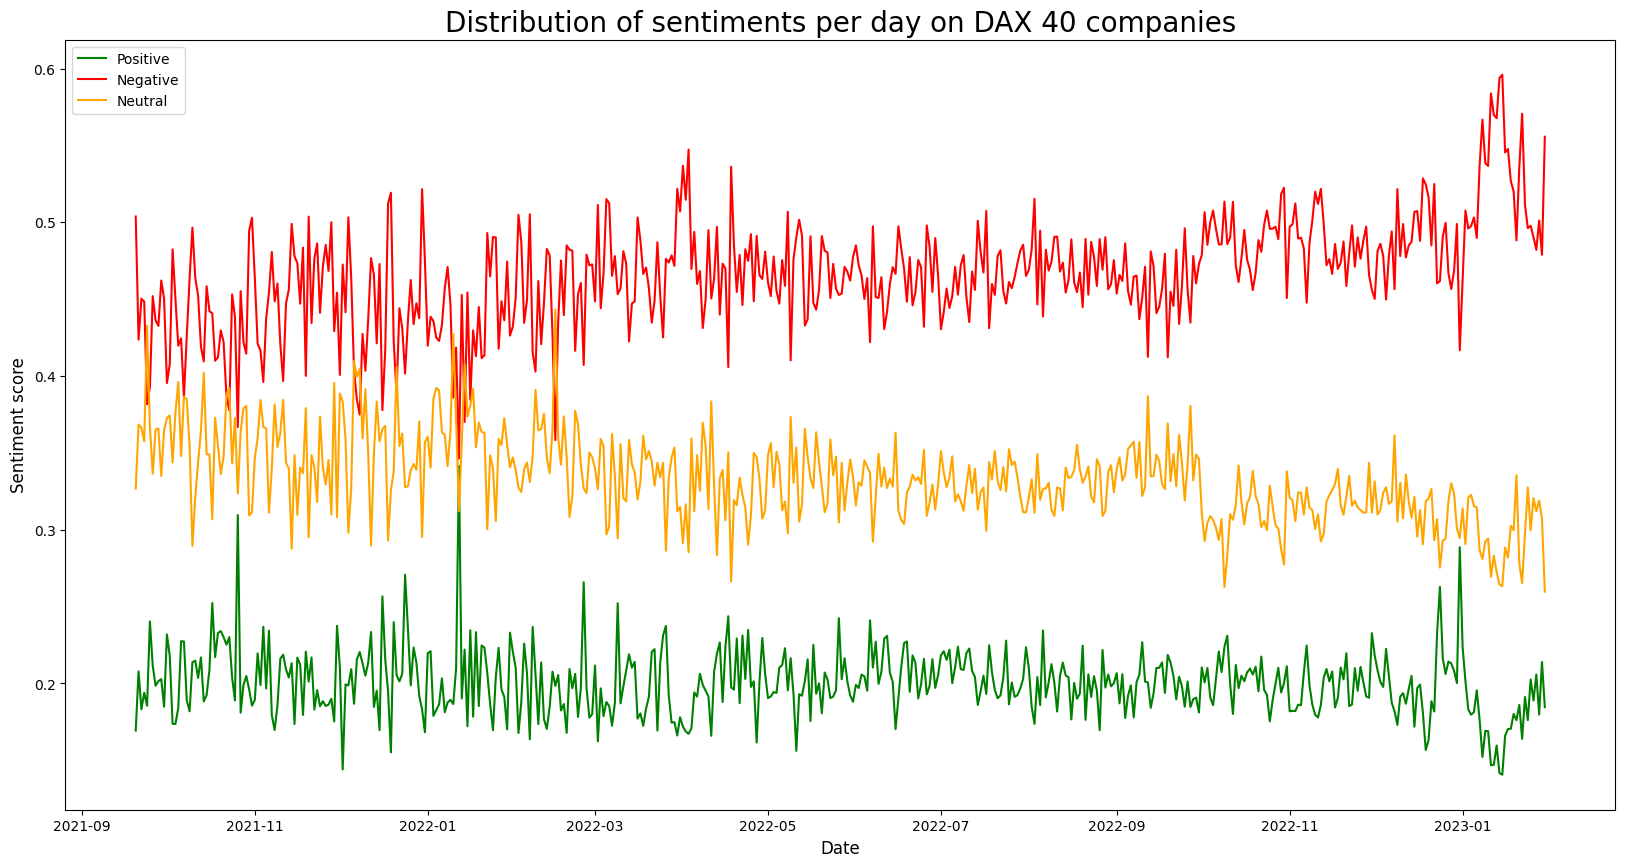

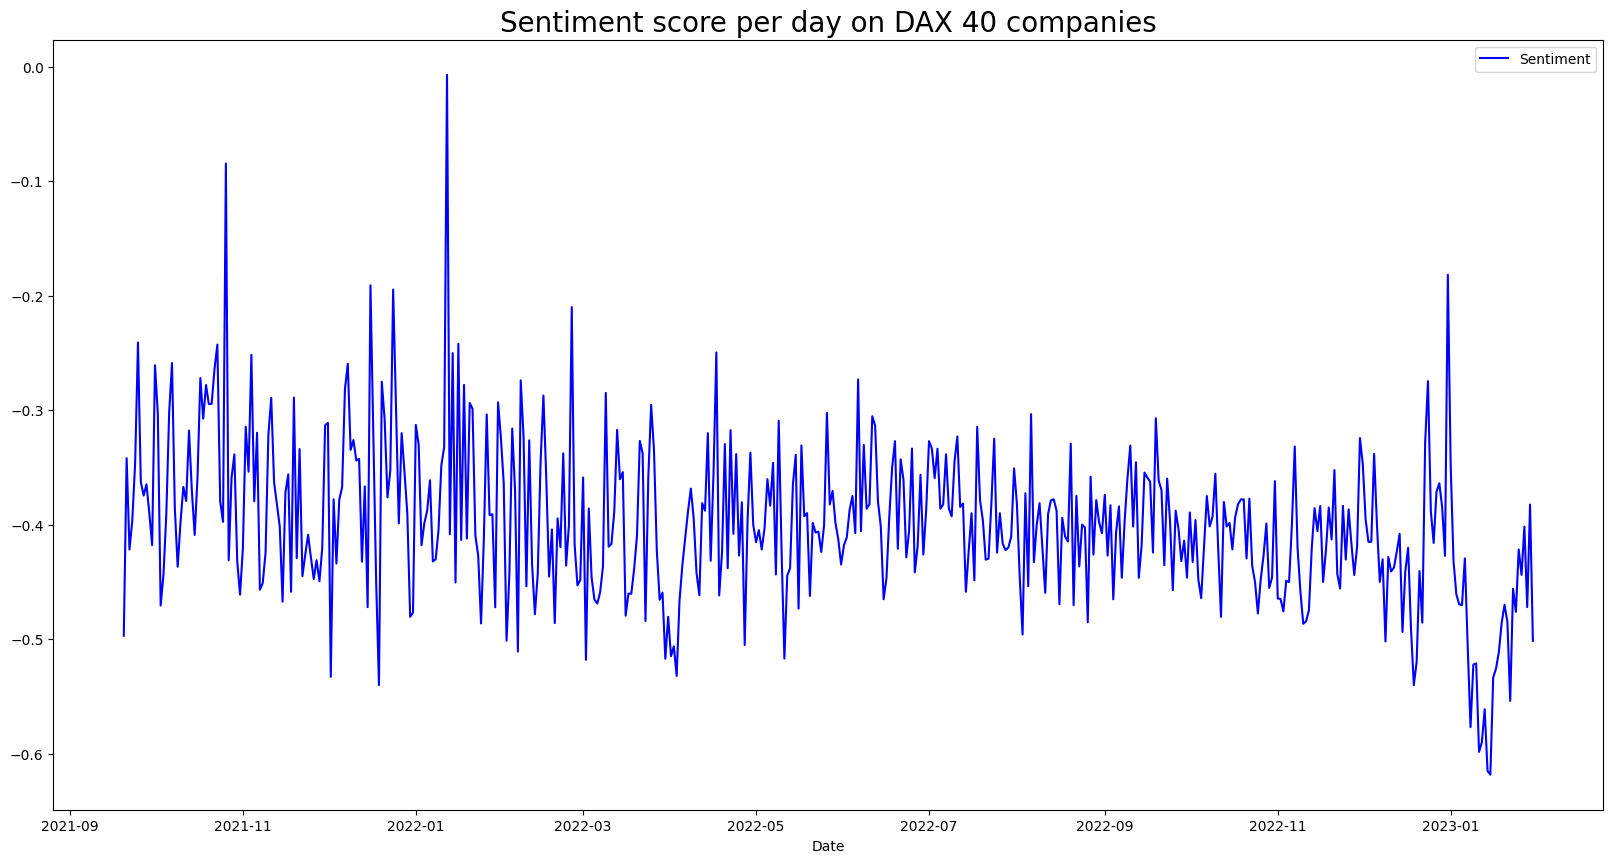

In [2]:
import pandas as pd
import re
import tqdm
import matplotlib.pyplot as plt

# Read the csv file
tweets = pd.read_csv('tweets_dax_40_sentiment.csv', sep=';')
print(tweets.head())
# Now calculate the sentiment score for each tweet
tweets['Sentiment'] = (tweets['Positive'] - tweets['Negative'])/(tweets['Positive'] + tweets['Negative'])
print(tweets["Sentiment"].head(10))
#drop duplicates
tweets = tweets.drop_duplicates(subset=['Text'])

# Plot the sentiment score per day
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'])
tweets['Date'] = tweets['Datetime'].dt.date
tweets_per_day = tweets.groupby('Date').mean()
print(tweets_per_day.head())
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day = tweets_per_day[['Date', 'Positive', 'Negative', 'Neutral']]
tweets_per_day.columns = ['Date', 'Positive', 'Negative', 'Neutral']
tweets_per_day = tweets_per_day.sort_values(by='Date', ascending=True)
tweets_per_day.plot(x='Date', y=['Positive', 'Negative', 'Neutral'], kind='line', figsize=(20, 10),color=['g', 'r', 'orange'])
plt.title("Distribution of sentiments per day on DAX 40 companies", fontsize=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sentiment score", fontsize=12)
plt.show()

#plot only the daily sentiment score
tweets_per_day['Sentiment'] = (tweets_per_day['Positive'] - tweets_per_day['Negative'])/(tweets_per_day['Positive'] + tweets_per_day['Negative'])
tweets_per_day.plot(x='Date', y='Sentiment', kind='line', figsize=(20, 10),color=['b'])
plt.title("Sentiment score per day on DAX 40 companies", fontsize=20)
plt.show()

# Save the tweets in a csv file
tweets.to_csv("tweets_dax_40_business.csv",sep=";")
tweets_per_day.to_csv("tweets_dax_40_business_per_day.csv",sep=";")

Merge Files

C:\Users\Maximilian Horstmann\AppData\Local\Temp\ipykernel_30312\2955858472.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df=df.resample('D').mean()


             Unnamed: 0.5   Unnamed: 0.4   Unnamed: 0.3   Unnamed: 0.2  \
Datetime                                                                 
2021-09-20  199109.880000  199109.880000  199109.880000  199109.880000   
2021-09-21  198981.011494  198981.011494  198981.011494  198981.011494   
2021-09-22  198869.177966  198869.177966  198869.177966  198869.177966   
2021-09-23  198739.656000  198739.656000  198739.656000  198739.656000   
2021-09-24  198604.609756  198604.609756  198604.609756  198604.609756   

             Unnamed: 0.1     Unnamed: 0      Tweet Id      Likes   Replies  \
Datetime                                                                      
2021-09-20  199109.880000  199109.880000  1.439949e+18   4.953333  0.940000   
2021-09-21  198981.011494  198981.011494  1.440304e+18   5.919540  0.528736   
2021-09-22  198869.177966  198869.177966  1.440665e+18  10.050847  0.754237   
2021-09-23  198739.656000  198739.656000  1.441032e+18   7.632000  0.504000   
2021-09

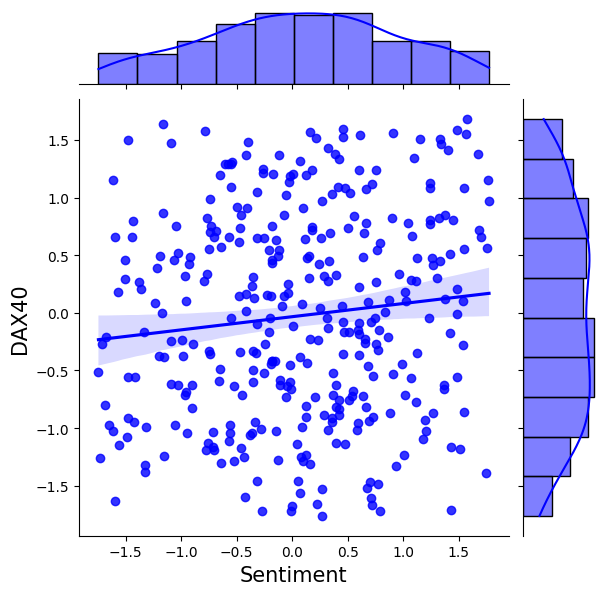

<Figure size 1000x1000 with 0 Axes>

In [4]:
# Scrape the Index data for DAX40 from Yahoo Finance
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Get the data for the stock Dax from 2021-09-20 until 2023-01-31
data = yf.download('^GDAXI', start='2021-09-20', end='2023-01-31', progress=False)
data = data.reset_index()
data = data[['Date', 'Close']]
data.columns = ['Date', 'DAX']
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)

# Set the index to the Date column
data = data.set_index('Date')

# Change the close price to the daily change in percent


# Import the tweets dax_40_sentiment.csv
#read data
df=pd.read_csv('tweets_dax_40_business.csv', sep=';')

#convert date to datetime
df['Datetime']=pd.to_datetime(df['Datetime'])
df['Datetime'].tz=None
df['Datetime']=df['Datetime'].dt.date

#set date as index
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

#summarize data per day
df=df.resample('D').mean()
print(df.head())

#sentiment difference
df['Sentiment']=df['Sentiment'].diff()
df['Positive']=df['Positive'].diff()
df['Negative']=df['Negative'].diff()
df['Neutral']=df['Neutral'].diff()
#nan values to rolling mean of five	
df['Sentiment']=df['Sentiment'].fillna(df['Sentiment'].rolling(5).mean())
df['Positive']=df['Positive'].fillna(df['Positive'].rolling(5).mean())
df['Negative']=df['Negative'].fillna(df['Negative'].rolling(5).mean())
df['Neutral']=df['Neutral'].fillna(df['Neutral'].rolling(5).mean())

#calcaulate z-score with a rolling window of 5 days
df['zscore_sent']=(df['Sentiment']-df['Sentiment'].rolling(5).mean())/df['Sentiment'].rolling(5).std()
df['zscore_pos']=(df['Positive']-df['Positive'].rolling(5).mean())/df['Positive'].rolling(5).std()
df['zscore_neg']=(df['Negative']-df['Negative'].rolling(5).mean())/df['Negative'].rolling(5).std()
df['zscore_neu']=(df['Neutral']-df['Neutral'].rolling(5).mean())/df['Neutral'].rolling(5).std()

# Merge the two dataframes
merged = pd.merge(data, df, left_index=True, right_index=True,how="outer")
merged = merged[['DAX', 'Positive','Neutral','Negative','Sentiment','zscore_sent','zscore_pos','zscore_neg','zscore_neu']]
# calculate diff for dax column take next value with numeric value if nan
merged.dropna(subset=['DAX'], inplace=True)
merged['DAX']=merged['DAX'].diff()
#calculate z-score with a rolling window of 5 days
merged['zscore_dax']=(merged['DAX']-merged['DAX'].rolling(5).mean())/merged['DAX'].rolling(5).std()

#drop nan values

print(merged.head(10))

#plot correlation between z-score of sentiment and z-score of close price
sns.jointplot(x='zscore_sent', y='zscore_dax', data=merged, kind='reg', color='blue')
#add title and labels
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('DAX40', fontsize=15)
plt.figure(figsize=(10,10))
plt.show()

# Save the merged data in a csv file
merged.to_csv("dax_40_per_day.csv",sep=";")


Conducting AD Fuller Test

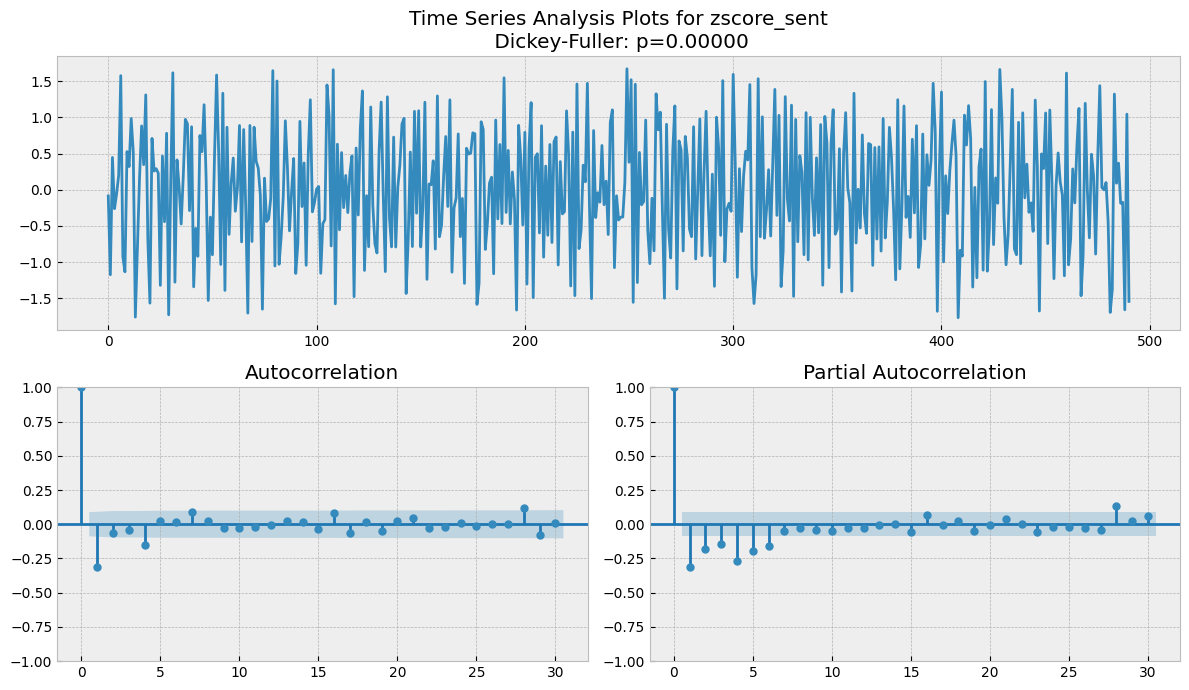

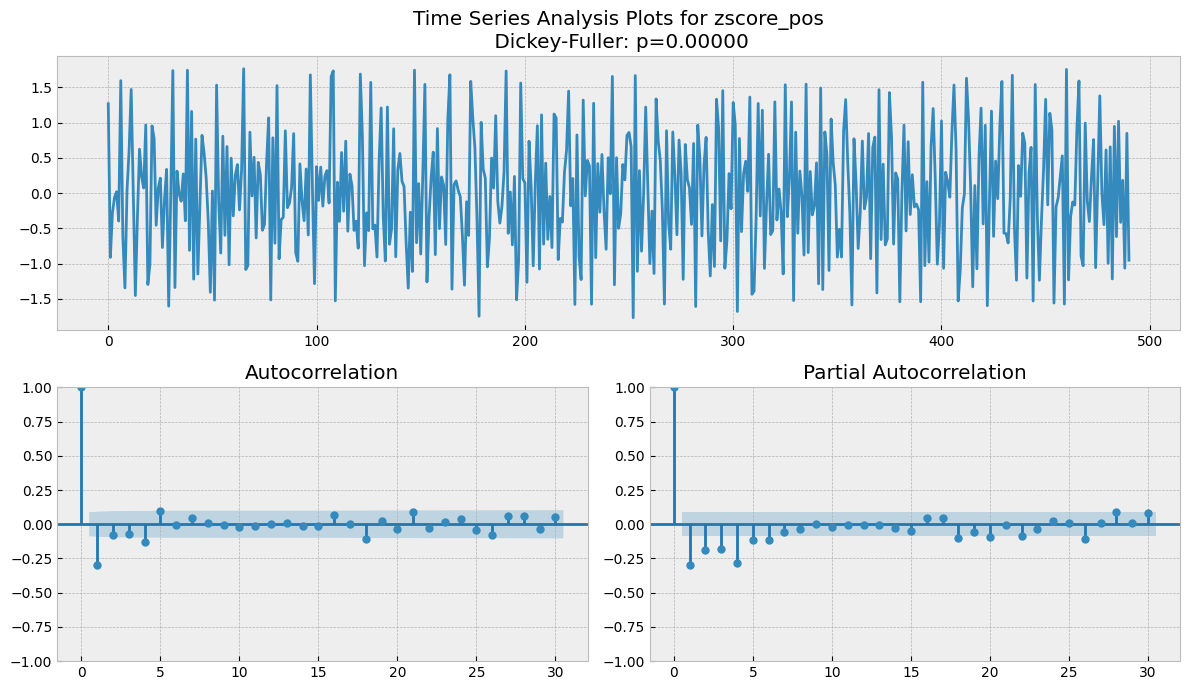

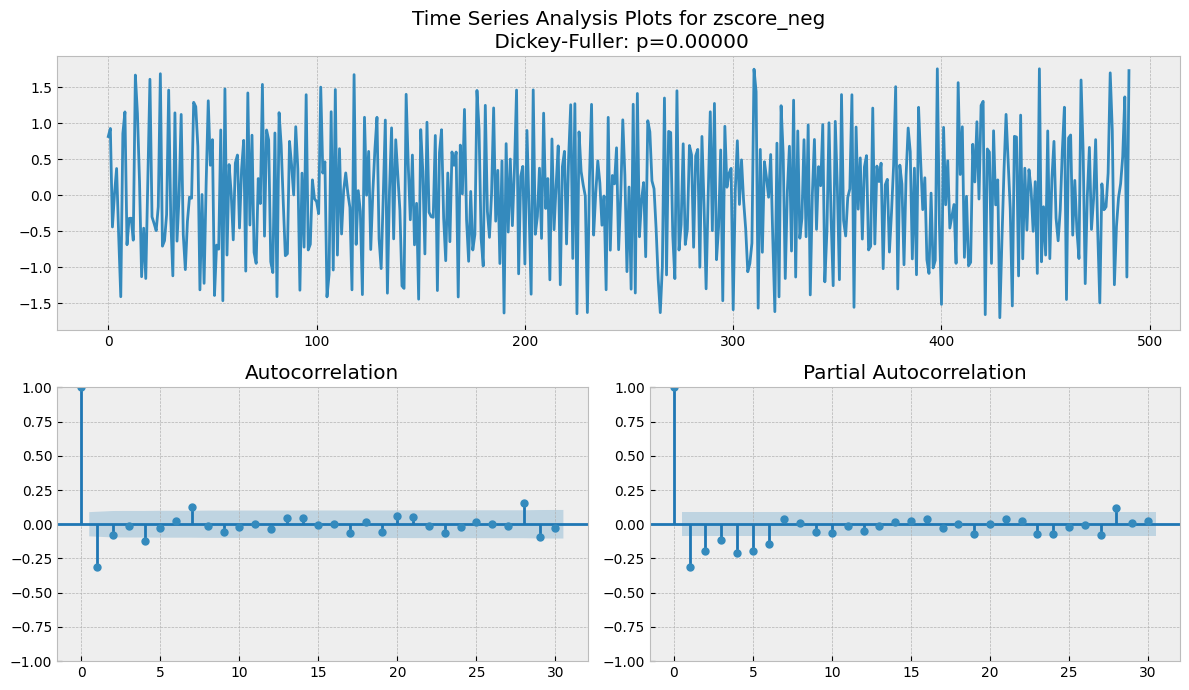

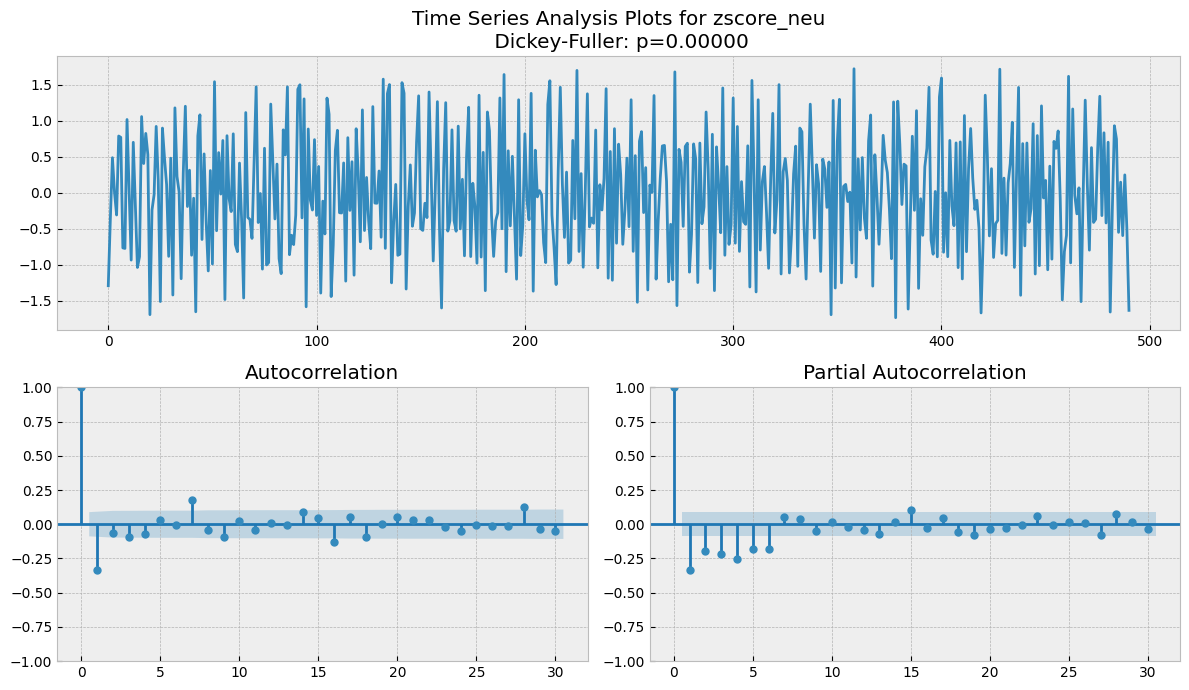

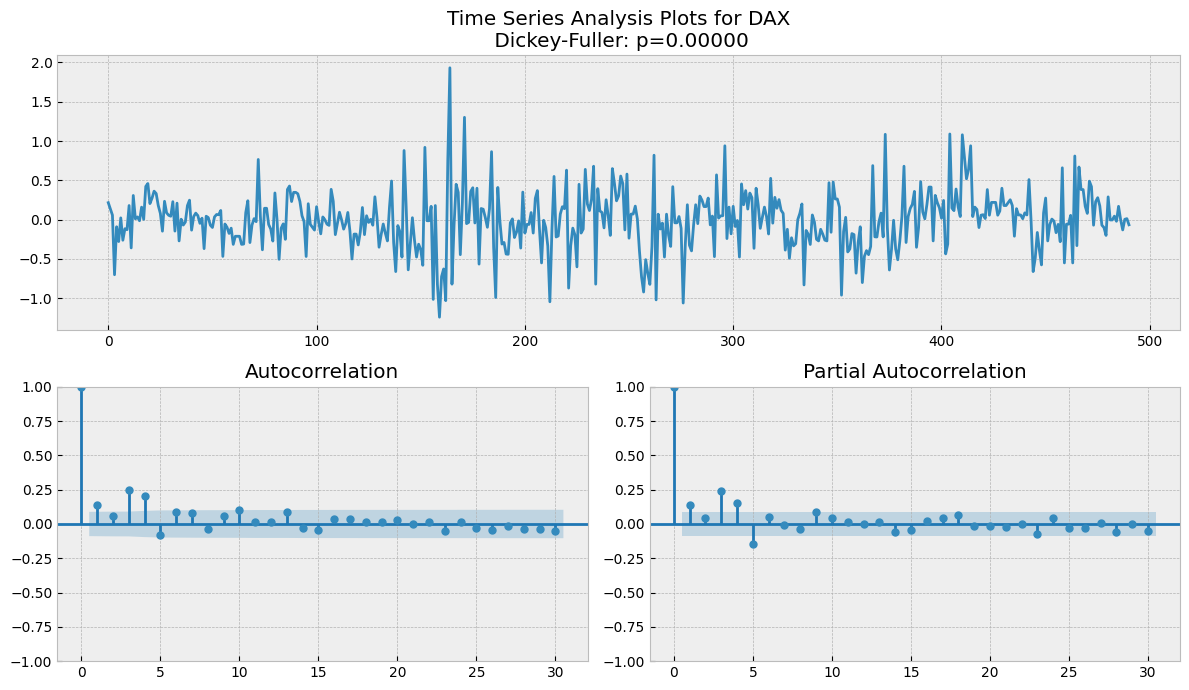

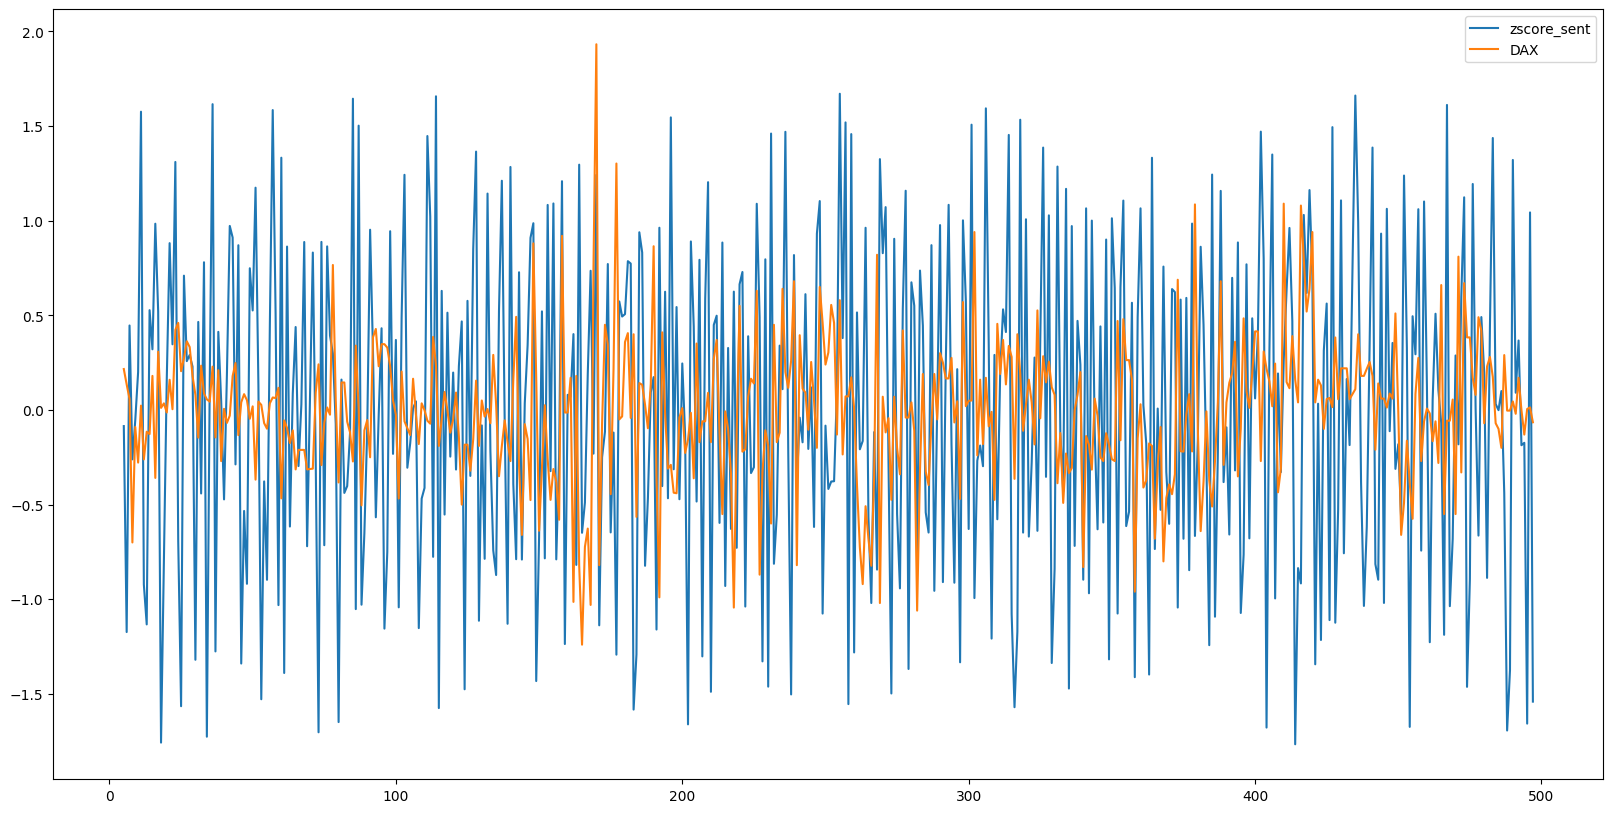

In [98]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Import the tagged tweets and the tweets with the tag 'business'
#read data
df=pd.read_csv("dax_40_per_day.csv", sep=';')

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots for '+str(col)+'\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
cols=['zscore_sent','zscore_pos','zscore_neg','zscore_neu','DAX']
for col in cols:
    tsplot(df[col], lags=30)   
    
# plot dax and sentiment in a line chart
merged.plot(y=['zscore_sent', 'DAX'], kind='line', figsize=(20, 10))
plt.show()





Show Correlation between Sentiment and Stock Price

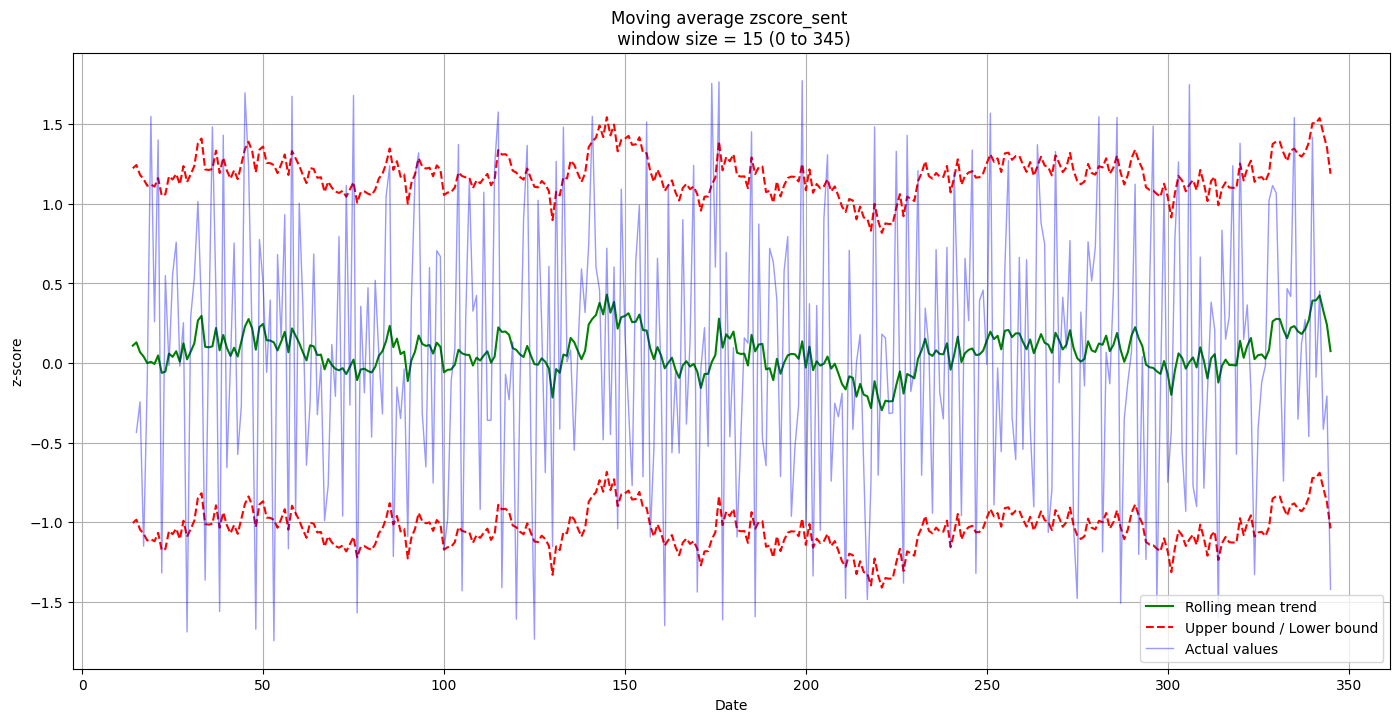

In [46]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

#define function for moving average plot

def plot_moving_average(series, window, plot_intervals=False, scale=0.5):
    rolling_mean = series.rolling(window=window).mean()
    
    # Get the date range for the rolling mean
    start_date = rolling_mean.index[0]
    end_date = rolling_mean.index[-1]
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average zscore_sent \n window size = {} ({} to {})'.format(window, start_date, end_date))
    
    # Set x axis column and set to datetime
    plt.xlabel('Date')
    plt.ylabel('z-score')

    
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    
    # Plot values in background and transparent
    plt.plot(series[window:], label='Actual values', alpha=0.4, color='blue',linewidth=1)
    plt.legend(loc='best')
    plt.grid(True)





#import data
data=pd.read_csv("dax_40_per_day.csv", sep=';')
data.dropna(subset=['zscore_sent'], inplace=True)
#reset index
data=data.reset_index(drop=True)


#plot moving average with window size 30
plot_moving_average(data.zscore_sent, 15, plot_intervals=True)

granger causality matrix

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load your data into a pandas dataframe
data = pd.read_csv('dax_40_per_day.csv',sep=';')
data['Sentiment']=data['zscore_sent']
data['Positive']=data['zscore_pos']
data['Neutral']=data['zscore_neu']
data['Negative']=data['zscore_neg']

#drop the first 5 rows
data=data.drop(data.index[0:5])

# Set the lag values
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Create a table to store the p-values
table = pd.DataFrame(index=lags, columns=['Sentiment', 'Positive', 'Neutral', 'Negative'])

# Iterate over the variables and lag values
for var in ['Sentiment', 'Positive', 'Neutral', 'Negative']:
    for lag in lags:
        # Perform Granger causality test for each lag value
        results = grangercausalitytests(data[["zscore_dax",var]], maxlag=lag, verbose=False)
        # Extract the p-value
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < 0.1 and p_value > 0.05:
            p_value_str = f'*{p_value:.4f}'
        elif p_value < 0.05 and p_value > 0.01:
            p_value_str = f'**{p_value:.4f}'
        elif p_value < 0.01:
            p_value_str = f'***{p_value:.4f}'
        else:
            p_value_str = f'{p_value:.4f}'
        table.loc[lag, var] = p_value_str
# Print the table
print(table)

#convert table to csv
table.to_csv('granger_causality_dax.csv', sep=';')

print('test the other way around')

#conduct granger causality the other way around
table = pd.DataFrame(index=lags, columns=['Sentiment', 'Positive', 'Neutral', 'Negative'])

# Iterate over the variables and lag values
for var in ['Sentiment', 'Positive', 'Neutral', 'Negative']:
    for lag in lags:
        # Perform Granger causality test for each lag value
        results = grangercausalitytests(data[[var,'zscore_dax']], maxlag=lag, verbose=False)
        # Extract the p-value
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < 0.1 and p_value > 0.05:
            p_value_str = f'*{p_value:.4f}'
        elif p_value < 0.05 and p_value > 0.01:
            p_value_str = f'**{p_value:.4f}'
        elif p_value < 0.01:
            p_value_str = f'***{p_value:.4f}'
        else:
            p_value_str = f'{p_value:.4f}'
        table.loc[lag, var] = p_value_str
# Print the table
print(table)




   Sentiment Positive Neutral  Negative
1   **0.0139   0.2210  0.1658  **0.0332
2    *0.0554   0.2908  0.3406   *0.0950
3     0.1212   0.3655  0.6009    0.1990
4     0.2454   0.4758  0.5843    0.3236
5     0.2253   0.3133  0.7046    0.2922
6     0.3593   0.3929  0.8334    0.3646
7     0.3583   0.3449  0.8393    0.4691
8     0.3492   0.2645  0.6623    0.5893
9     0.3102   0.2575  0.7538    0.5104
10    0.3645   0.3164  0.8298    0.6102
11    0.4590   0.3763  0.7623    0.6631
12    0.4157   0.4773  0.7720    0.6068
test the other way around
   Sentiment Positive  Neutral Negative
1     0.5268   0.7121   0.6713   0.5071
2     0.4660   0.9401  *0.0708   0.2184
3     0.3935   0.9639   0.1032   0.1277
4     0.5385   0.9866   0.1857   0.2278
5     0.4437   0.9514   0.2173   0.4539
6     0.1637   0.7166   0.2822   0.4284
7     0.2413   0.4895   0.2563   0.5244
8     0.2974   0.3377   0.2749   0.5360
9     0.3522   0.3112   0.2516   0.4246
10    0.4227   0.2957   0.2622   0.4494
11    0.4508  

Try the same thing with dax as a binary variable

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Load your data into a pandas dataframe
data = pd.read_csv('dax_40_per_day.csv',sep=';')
data['Sentiment']=data['zscore_sent']
data['Positive']=data['zscore_pos']
data['Neutral']=data['zscore_neu']
data['Negative']=data['zscore_neg']
# create new column dax_bin with 0 if dax is negative and 1 if dax is positive
data['dax_bin']=np.where(data['DAX'] > 0, 1, 0)
#drop the first 5 rows
data=data.drop(data.index[0:5])

# Set the lag values
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Create a table to store the p-values
table = pd.DataFrame(index=lags, columns=['Sentiment', 'Positive', 'Neutral', 'Negative'])

# Iterate over the variables and lag values
for var in ['Sentiment', 'Positive', 'Neutral', 'Negative']:
    for lag in lags:
        # Perform Granger causality test for each lag value
        results = grangercausalitytests(data[["dax_bin",var]], maxlag=lag, verbose=False)
        # Extract the p-value
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < 0.1 and p_value > 0.05:
            p_value_str = f'*{p_value:.4f}'
        elif p_value < 0.05 and p_value > 0.01:
            p_value_str = f'**{p_value:.4f}'
        elif p_value < 0.01:
            p_value_str = f'***{p_value:.4f}'
        else:
            p_value_str = f'{p_value:.4f}'
        table.loc[lag, var] = p_value_str
# Print the table
print(table)

#table to csv
table.to_csv('granger_causality_dax_bin.csv', sep=';')

print('test the other way around')

#conduct granger causality the other way around
table = pd.DataFrame(index=lags, columns=['Sentiment', 'Positive', 'Neutral', 'Negative'])

# Iterate over the variables and lag values
for var in ['Sentiment', 'Positive', 'Neutral', 'Negative']:
    for lag in lags:
        # Perform Granger causality test for each lag value
        results = grangercausalitytests(data[[var,"dax_bin"]], maxlag=lag, verbose=False)
        # Extract the p-value
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < 0.1 and p_value > 0.05:
            p_value_str = f'*{p_value:.4f}'
        elif p_value < 0.05 and p_value > 0.01:
            p_value_str = f'**{p_value:.4f}'
        elif p_value < 0.01:
            p_value_str = f'***{p_value:.4f}'
        else:
            p_value_str = f'{p_value:.4f}'
        table.loc[lag, var] = p_value_str

# Print the table
print(table)

    Sentiment   Positive Neutral  Negative
1   ***0.0053  ***0.0027  0.9456  **0.0222
2    **0.0186  ***0.0083  0.8734   *0.0659
3     *0.0508   **0.0199  0.9640    0.1282
4     *0.0897   **0.0414  0.6972    0.2245
5     *0.0884   **0.0480  0.7852    0.2164
6      0.1284    *0.0617  0.8784    0.2828
7      0.1937    *0.0757  0.8404    0.3779
8      0.1167   **0.0210  0.8095    0.3696
9      0.1269   **0.0351  0.8701    0.3310
10     0.1716    *0.0629  0.9188    0.4243
11     0.2551     0.1162  0.5822    0.4801
12     0.3606     0.1740  0.5460    0.5157
test the other way around
    Sentiment Positive   Neutral  Negative
1     *0.0756   0.2668    0.6988    0.1475
2      0.1017   0.6229  **0.0319   *0.0512
3    **0.0111   0.2244  **0.0457  **0.0249
4   ***0.0092   0.1831   *0.0855  **0.0180
5    **0.0209   0.3167   *0.0841   *0.0598
6    **0.0314   0.4059   *0.0797   *0.0919
7     *0.0695   0.3178   *0.0725    0.1979
8     *0.0507   0.2142   *0.0985    0.2450
9     *0.0655   0.2691    0.

Trying ARIMA modelling 

In [11]:
#import packages
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#define algorithm that will create all possible combinations of variables (univariate, bivariate, trivariate and quadrivariate)
def generate_arima_models(a, b, c, d, train):
    univariate_combinations = [[a], [b], [c], [d]]
    bivariate_combinations = list(itertools.combinations([a, b, c, d], 2))
    trivariate_combinations = list(itertools.combinations([a, b, c, d], 3))
    quadrivariate_combinations = [(a, b, c, d)]
    print(f'Univariate: {len(univariate_combinations)}')
    print(f'Bivariate: {len(bivariate_combinations)}')
    print(f'Trivariate: {len(trivariate_combinations)}')
    print(f'Quadrivariate: {len(quadrivariate_combinations)}')

    models = []

    # Iterate over the variables and lag values
    for var in tqdm(univariate_combinations + bivariate_combinations + trivariate_combinations + quadrivariate_combinations):
        for p in range(1, 13):
            for q in range(1, 13):
                # specify the predictor and target variables
                X = train[list(var)]
                y = train['zscore_dax']
                # fit an ARIMA model
                try:
                    model = ARIMA(y, order=(p, 0, q), exog=X)
                    results = model.fit()
                    models.append([var, p, q, results.aic])
                except np.linalg.LinAlgError as e:
                    print(f"Error fitting model for {var} with p={p} and q={q}: {e}")

    #create dataframe with all models
    models = pd.DataFrame(models, columns=['var', 'p', 'q', 'aic'])
    return models

#load data
data = pd.read_csv('dax_40_per_day.csv',sep=';')

#dropnan
data = data.dropna()

#define train and test data
train, test = train_test_split(data, test_size=0.2, shuffle=False)

#run algorithm with train data
models = generate_arima_models('zscore_sent', 'zscore_pos', 'zscore_neg', 'zscore_neu', train)

#to csv
models.to_csv('models_d.csv', index=False)

#print 3 models with lowest aic
print(models.sort_values('aic').head(3))

Univariate: 4
Bivariate: 6
Trivariate: 4
Quadrivariate: 1


100%|██████████| 15/15 [9:47:21<00:00, 2349.45s/it]  

                           var  p   q         aic
681  (zscore_sent, zscore_pos)  9  10   46.000000
38               [zscore_sent]  4   3  688.746898
327               [zscore_neg]  4   4  689.434746


Analyzing Best-Fit model for measures of fit

In [7]:
import numpy as np
import scipy.stats as stats
import tensorflow as tf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

#calculate MAPE with significance test
def mape(y_true, y_pred):
    mape_val = np.mean(np.abs((y_true - y_pred) / y_true))
    print("MAPE:", mape_val)
    #calculate p value
    p_value = stats.ttest_rel(y_true, y_pred)[1]
    print("MAPE p-value:", p_value)
    return mape_val

#calculate direction accuracy
def mda(y, y_hat):
    assert len(y) == len(y_hat), "Lengths of y and y_hat must be the same."
    c = tf.equal(tf.sign(y[1:] - y[:-1]), tf.sign(y_hat[1:] - y_hat[:-1]))
    mda_val = tf.reduce_mean(tf.cast(c, tf.float32))
    _, p_value = stats.wilcoxon(y-y_hat)
    print("MDA:", mda_val)
    print("MDA p-value:", p_value)
    return mda_val

#load data
data = pd.read_csv('dax_40_per_day.csv',sep=';')
models=pd.read_csv('models_d.csv',sep=';')

#dropnan
data=data.dropna()

#split train and test data
train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]

#specify the predictor and target variables
X_train = train[['zscore_sent']]
y_train = train['zscore_dax']
X_test = test[['zscore_sent']]
y_test = test['zscore_dax']

# fit an ARIMA model
model = ARIMA(y_train, order=(4, 0, 3), exog=X_train)
results = model.fit()
print(results.summary())

#predict test data
y_pred = results.predict(start=len(train), end=len(data)-1, exog=X_test)
y_pred = pd.Series(y_pred, index=test.index)
y_pred=y_pred.dropna()

#make length of y_pred and y_test the same
y_test=y_test[:len(y_pred)]


#calculate MAPE
mape_val = mape(y_test, y_pred)

#calculate directional accuracy
mda_val = mda(y_test, y_pred)

#now try the same with the model with zscore_neg and p=4 and q=4
#specify the predictor and target variables
X_train = train[['zscore_neg']]
y_train = train['zscore_dax']
X_test = test[['zscore_neg']]
y_test = test['zscore_dax']

# fit an ARIMA model
model = ARIMA(y_train, order=(4, 0, 4), exog=X_train)
results = model.fit()
print(results.summary())

#predict test data
y_pred = results.predict(start=len(train), end=len(data)-1, exog=X_test)
y_pred = pd.Series(y_pred, index=test.index)
y_pred=y_pred.dropna()

#make length of y_pred and y_test the same
y_test=y_test[:len(y_pred)]


#calculate MAPE
mape_val = mape(y_test, y_pred)

#calculate directional accuracy
mda_val = mda(y_test, y_pred)
print(y_test.isnull().sum())





c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

                               SARIMAX Results                                
Dep. Variable:             zscore_dax   No. Observations:                  276
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -334.373
Date:                Sun, 30 Apr 2023   AIC                            688.747
Time:                        11:19:18   BIC                            724.951
Sample:                             0   HQIC                           703.275
                                - 276                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0222      0.018     -1.232      0.218      -0.058       0.013
zscore_sent     0.1265      0.060      2.104      0.035       0.009       0.244
ar.L1          -0.4500      0.084     -5.343    

c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Maximilian Horstmann\AppData\Local\Programs\Python\Python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


lets compare best fit model vs ARIMA model for dax only

In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

# load data
data = pd.read_csv('dax_40_per_day.csv', sep=';').dropna()

#split train and test data
train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]
y=train['zscore_dax']

# create empty DataFrame to store AIC values
aic_df = pd.DataFrame(columns=['p', 'q', 'aic'])

# iterate through all combinations of p and q
for p in tqdm(range(1, 13)):
    for q in range(1, 13):
        # fit ARIMA model and get AIC
        model = ARIMA(y, order=(p, 0, q))
        results = model.fit()
        aic = results.aic
        
        # append to DataFrame
        aic_df = aic_df.append({'p': p, 'q': q, 'aic': aic}, ignore_index=True)

# find model with lowest AIC
min_aic = aic_df['aic'].min()
best_model = aic_df[aic_df['aic'] == min_aic]

# print results
print("Model with lowest AIC:")
print(best_model)


100%|██████████| 12/12 [03:45<00:00, 18.81s/it]

Model with lowest AIC:
      p    q         aic
13  2.0  2.0  691.853127


In [14]:
# print results
print("Model with lowest AIC:")
print(best_model)


Model with lowest AIC:
      p    q         aic
13  2.0  2.0  691.853127
